In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

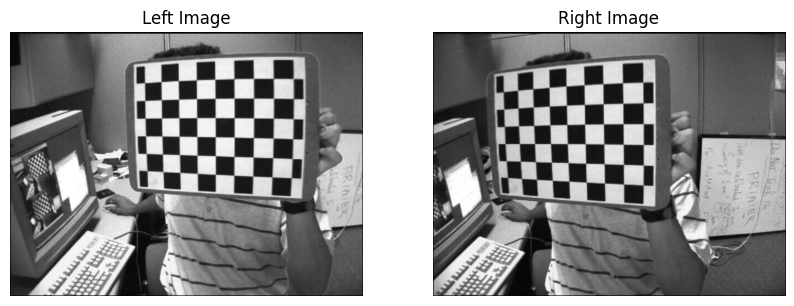

In [2]:
images_left = list(sorted(glob.glob('../dataset/stereo_calibration_data/calibration_left/left*.jpg')))
images_right = list(sorted(glob.glob('../dataset/stereo_calibration_data/calibration_right/right*.jpg')))
images_left = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in images_left]
images_right = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in images_right]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images_left[0], cmap='gray')
plt.title('Left Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(images_right[0], cmap='gray')
plt.title('Right Image')
plt.axis('off')
plt.show()

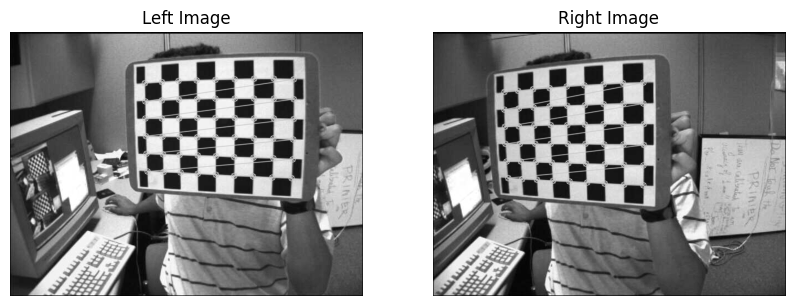

In [3]:
CBROW = 6
CBCOL = 9

# listas que armazenam os pontos 3D e 2D
objpoints = [] # pontos 3D do mundo real
left_points, right_points = [], [] # pontos 2D do plano da imagem
 
for left_image, right_image in zip(images_left, images_right):
    # procura os cantos do ChessBoard
    ret_left, corners_left = cv2.findChessboardCorners(left_image, (CBCOL,CBROW))
    ret_right, corners_right = cv2.findChessboardCorners(right_image, (CBCOL,CBROW))
    if ret_left and ret_right:
        left_points.append(corners_left)
        right_points.append(corners_right)

# prepara a matriz de pontos 3D do ChessBoard
objp = np.zeros((CBROW * CBCOL, 3), np.float32)
objp[:, :2] = np.mgrid[0:CBCOL, 0:CBROW].T.reshape(-1, 2)
 
objpoints = [objp] * len(left_points)

# desenhas os pontos nas imagens e exibe
img_test_left = np.copy(images_left[0])
img_test_right = np.copy(images_right[0])
img_left_chessboard = cv2.drawChessboardCorners(img_test_left, (CBCOL,CBROW), left_points[0], True)
img_right_chessboard = cv2.drawChessboardCorners(img_test_right, (CBCOL,CBROW), right_points[0], True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_left_chessboard, cmap='gray')   
plt.title('Left Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_right_chessboard, cmap='gray')
plt.title('Right Image')
plt.axis('off')
plt.show()

In [7]:
err, Kl, Dl, Kr, Dr, R, T, E, F = cv2.stereoCalibrate(objpoints, left_points, right_points, 
                                                      None, None, None, None, (left_image.shape[1], left_image.shape[0]), flags=0)
print('Left camera:')
print(Kl)
print('Left camera distortion:')
print(Dl)
print('Right camera:')
print(Kr)
print('Right camera distortion:')
print(Dr)
print('Rotation matrix:')
print(R)
print('Translation:')
print(T)
print('Error:')
print(err)

Left camera:
[[532.53097768   0.         342.16062229]
 [  0.         532.49314171 235.84000174]
 [  0.           0.           1.        ]]
Left camera distortion:
[[-0.27370709 -0.02314409  0.00123698 -0.00032979  0.24019462]]
Right camera:
[[536.00074016   0.         327.83495195]
 [  0.         535.67104646 250.29109128]
 [  0.           0.           1.        ]]
Right camera distortion:
[[-0.29521598  0.11558964 -0.00063852 -0.00053123 -0.00781429]]
Rotation matrix:
[[ 0.99998925  0.00355611  0.0029745 ]
 [-0.00353802  0.99997535 -0.006065  ]
 [-0.002996    0.00605441  0.99997718]]
Translation:
[[-3.33007684]
 [ 0.04017118]
 [-0.00792075]]
Error:
0.39150230227899985


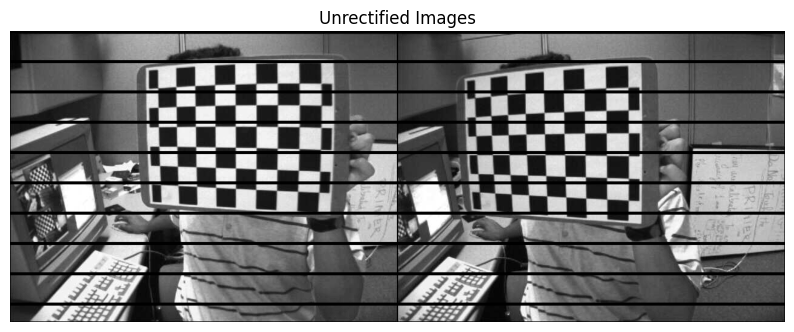

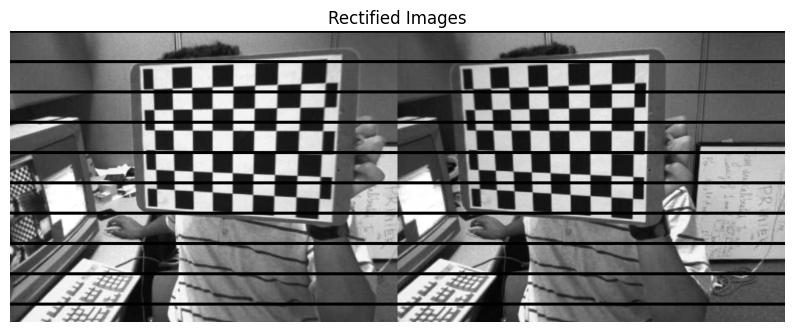

In [29]:
# Retificação estéreo
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(Kl, Dl, Kr, Dr, (left_image.shape[1], left_image.shape[0]), R, T)

# Mapas de remapeamento
map1_left, map2_left = cv2.initUndistortRectifyMap(Kl, Dl, R1, P1, (left_image.shape[1], left_image.shape[0]), cv2.CV_32FC1)
map1_right, map2_right = cv2.initUndistortRectifyMap(Kr, Dr, R2, P2, (right_image.shape[1], right_image.shape[0]), cv2.CV_32FC1)

# Aplicar remapeamento para retificar as imagens
rectified_left = cv2.remap(images_left[0], map1_left, map2_left, cv2.INTER_LINEAR)
rectified_right = cv2.remap(images_right[0], map1_right, map2_right, cv2.INTER_LINEAR)

image_normal = np.hstack((images_left[0], images_right[0]))
image_combined = np.hstack((rectified_left, rectified_right))

for i in range(0, image_combined.shape[1], 50):
    cv2.line(image_combined, (0, i), (image_combined.shape[1], i), (0, 0, 0), 4)
    cv2.line(image_normal, (0, i), (image_normal.shape[1], i), (0, 0, 0), 4)
    
plt.figure(figsize=(10, 5))
plt.imshow(image_normal, cmap='gray')
plt.title('Unrectified Images')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(image_combined, cmap='gray')
plt.title('Rectified Images')
plt.axis('off')
plt.show()
